In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import model, model_utils, preprocessing_utils

<ipython-input-1-9988fdcd4f95>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# if using seasonal ARIMA
m = 12 # 60 minutes

In [99]:
raw_trunc_dir = "./data/raw/trunc/"
process_dir = "./data/processed/"

# overwrite = False means that the processing function will only run if the process data files do not exist
# overwrite = True => functions will run regardless
preprocessing_utils.processed(raw_trunc_dir, process_dir, overwrite=False)
A, X, metadata, cat2index, means, stds = preprocessing_utils.load(process_dir)

split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.8)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

In [100]:
train_original_speedband = preprocessing_utils.denormalize(train_original_data, stds, means)[:,0,:] # (roads, num_of_timesteps)
val_original_data_speedband = preprocessing_utils.denormalize(val_original_data, stds, means)[:,0,:] # (roads, num_of_timesteps)
test_original_data_speedband = preprocessing_utils.denormalize(test_original_data, stds, means)[:,0,:] # (roads, num_of_timesteps)

In [101]:
# series plot
series = pd.Series(train_original_speedband[0].flatten())
# series.plot(figsize=(10,8))
# plt.show()

# correlation across time on one road
series = pd.Series(train_original_speedband[0].flatten())
# autocorrelation_plot(series)

In [102]:
train = train_original_speedband[0].flatten() # choose only 1 road
val = val_original_data_speedband[0].flatten() # choose only 1 road
test = test_original_data_speedband[0].flatten() # choose only 1 road

train_val = np.append(train,val)
dataAll = np.concatenate([train,val,test])

In [103]:
# Btw, i do not understand how to properly set ARIMA parameters, so i am using autoarima haha
import pmdarima as pm
train_val = np.append(train,val)

# Fit your model
# model = pm.auto_arima(train_val, seasonal=True, m=m, trace=True, suppress_warning=True)
model = pm.auto_arima(dataAll,trace=True, suppress_warning=True)
# Best model:  ARIMA(2,0,3)(0,0,0)[0]

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future
# summary of fit model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16081.549, Time=8.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17131.681, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17077.689, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17050.579, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17129.681, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16102.692, Time=5.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16091.938, Time=7.33 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=16082.786, Time=10.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=16082.719, Time=13.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16171.514, Time=4.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=16085.326, Time=4.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=16080.920, Time=4.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=16720.748, Time=0.90 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=16082.753, Time=8.09 sec
 ARIMA(2,1,0)(0,0

In [116]:
from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(,order=(3,1,1))
num_of_input = 100
current_input = train_val[-num_of_input:].tolist()

limit = len(test)
num_of_pred = 1
pred = []
for i in range(0,len(test[:limit]), num_of_pred):
    model.fit(current_input)
    y = model.predict(n_periods=num_of_pred)
    pred.extend(y)
    
    current_input.pop()
    current_input.extend(y)

LinAlgError: LU decomposition error.

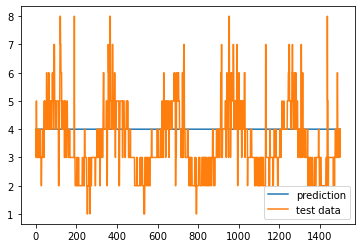

In [115]:
plt.plot(pred, label="prediction")
plt.plot(test[:limit], label="test data")
plt.legend()

In [16]:
from statsmodels.tsa.stattools import adfuller
dataAll = np.concatenate([train,val,test])
dftest = adfuller(dataAll, autolag='AIC')
print("1. ADF: ", dftest[0])
print("1. P-Value: ", dftest[1])
print("1. Num of lags: ", dftest[2])

1. ADF:  -7.72276805086147
1. P-Value:  1.1805577695945152e-11
1. Num of lags:  21


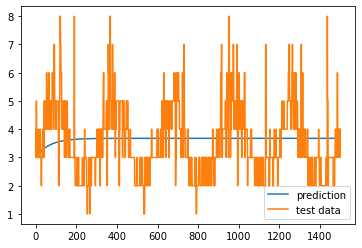

In [80]:
model.fit(train_val)

# predict the entire test data
num_of_pred = len(test)
pred = model.predict(n_periods=num_of_pred)

plt.plot(pred, label="prediction")
plt.plot(test[:num_of_pred], label="test data")
plt.legend()

In [97]:
# predict only 1 step at a time. Each time refit the data


done 1
done 1
done 1
done 1
done 1
done 1
done 1
done 1
done 1
done 1


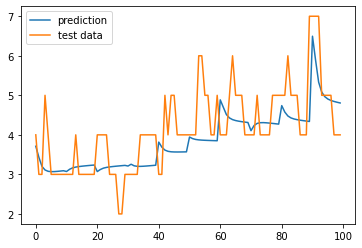

In [98]:
plt.plot(pred, label="prediction")
plt.plot(test[:limit], label="test data")
plt.legend()

# Example

C:\Users\Mario\Anaconda3\envs\pytorch\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(4,1,1)(2,0,2)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\Mario\Anaconda3\envs\pytorch\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\Mario\Anaconda3\envs\pytorch\lib\site-packages\pmdarima\arima\arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\Mario\Anaconda3\envs\pytorch\lib\site-packages\pmdarima\arima\arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\Mario\Anaconda3\envs\pytorch\lib\site-packages\pmdarima\arima\arima.py", line 393, in _fit_wrapper
    return arima, arima.fit(start_params=start_params,
  File "C:\Users\Mario\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\ml

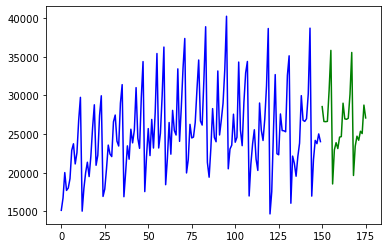

In [85]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
y = pm.datasets.load_wineind()
train, test = train_test_split(y, train_size=150)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=12)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:150], train, c='blue')
plt.plot(x[150:], forecasts, c='green')
plt.show()

In [86]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  150
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood               -1418.496
Date:                             Thu, 29 Apr 2021   AIC                           2848.992
Time:                                     17:40:33   BIC                           2867.016
Sample:                                          0   HQIC                          2856.315
                                             - 150                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0339      0.079     -0.430      0.667      -0.188       0.121
ar.L2         -0.2113      0.094     -2.247      0.025      -0.396      -0.027
ma.L1         -0.8622      0.017    -50.294      0.000      -0.896      -0.829
ar.S.L12       0.5045      0.043     11.845      0.000       0.421       0.588
ar.S.L24       0.3313      0.060      5.504      0.000       0.213       0.449
sigma2      9.567e+06   2.26e-09   4.23e+15      0.000    9.57e+06    9.57e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               461.47
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                             1.29
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.02e+30. Standard errors may be unstable.
"""